In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/Womens Clothing E-Commerce Reviews.csv')

# Display basic information
print(df.head())
print(df.info())


   Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1       

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import re

# Drop rows with missing values in text or ratings
df = df[['Review Text', 'Rating']].dropna()

# Map Ratings to Sentiment Labels
def map_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['Sentiment'] = df['Rating'].apply(map_sentiment)

# Clean the text data
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove non-alphabets
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing whitespace
    return text

df['Cleaned_Review'] = df['Review Text'].apply(clean_text)

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Cleaned_Review'], df['Sentiment'], test_size=0.2, random_state=42
)


In [ ]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize text
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch

# Encode labels
label_mapping = {'positive': 0, 'neutral': 1, 'negative': 2}
train_labels = train_labels.map(label_mapping).values
val_labels = val_labels.map(label_mapping).values

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}, torch.tensor(self.labels[idx])

train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset = ReviewDataset(val_encodings, val_labels)


In [ ]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader

# Load BERT with a classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Set up data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch
print(torch.cuda.is_available())  # Should print True


True


In [ ]:
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Gradient scaler for mixed precision (only works on GPU)
scaler = GradScaler(enabled=torch.cuda.is_available())

# Training loop parameters
epochs = 3
train_batch_size = 16  # Adjust batch size based on memory
val_batch_size = 16

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")

    for batch in progress_bar:
        # Unpack batch (assume batch = [inputs, labels])
        inputs, labels = batch
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to GPU/CPU
        labels = labels.to(device)  # Move labels to GPU/CPU

        optimizer.zero_grad()

        # Mixed precision forward pass (if GPU is available)
        with autocast(enabled=torch.cuda.is_available()):
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)

        # Backward pass and optimizer step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    print(f"Epoch {epoch + 1} completed. Total Loss: {total_loss:.4f}")

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validating Epoch {epoch + 1}"):
            # Unpack batch
            inputs, labels = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to GPU/CPU
            labels = labels.to(device)  # Move labels to GPU/CPU

            with autocast(enabled=torch.cuda.is_available()):
                outputs = model(**inputs)
                loss = loss_fn(outputs.logits, labels)

            total_val_loss += loss.item()
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    print(f"Epoch {epoch + 1} Validation Loss: {total_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


<ipython-input-9-008fc451b4b1>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
Training Epoch 1:   0%|          | 0/1132 [00:00<?, ?it/s]<ipython-input-9-008fc451b4b1>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
Training Epoch 1: 100%|██████████| 1132/1132 [02:24<00:00,  7.86it/s, loss=0.434]


Epoch 1 completed. Total Loss: 458.6039


Validating Epoch 1:   0%|          | 0/284 [00:00<?, ?it/s]<ipython-input-9-008fc451b4b1>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
Validating Epoch 1: 100%|██████████| 284/284 [00:08<00:00, 33.43it/s]


Epoch 1 Validation Loss: 97.8162, Accuracy: 0.8549


Training Epoch 2: 100%|██████████| 1132/1132 [02:24<00:00,  7.81it/s, loss=0.264]


Epoch 2 completed. Total Loss: 335.6322


Validating Epoch 2: 100%|██████████| 284/284 [00:08<00:00, 33.71it/s]


Epoch 2 Validation Loss: 97.5808, Accuracy: 0.8503


Training Epoch 3: 100%|██████████| 1132/1132 [02:25<00:00,  7.76it/s, loss=0.172]


Epoch 3 completed. Total Loss: 240.4258


Validating Epoch 3: 100%|██████████| 284/284 [00:08<00:00, 33.25it/s]

Epoch 3 Validation Loss: 115.2327, Accuracy: 0.8501


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Assuming you have a test or validation dataset and a trained model
# You can predict sentiments for each review in the test set like this

# Example function to predict sentiment labels for test data
def predict_sentiments(model, test_data, device):
    model.eval()  # Set model to evaluation mode
    predictions = []
    with torch.no_grad():  # Disable gradient calculation during inference
        for inputs in test_data:
            inputs = inputs.to(device)  # Move data to the GPU or CPU
            outputs = model(**inputs)   # Get model predictions
            logits = outputs.logits
            predicted_class = torch.argmax(logits, dim=1)  # Get the predicted class (0: Negative, 1: Neutral, 2: Positive)
            predictions.extend(predicted_class.cpu().numpy())  # Convert predictions to CPU and collect them
    return predictions

# Example of how you might call this function (replace `test_loader` and `model` with your actual data and model)
test_data = [...]  # Your test dataset here (e.g., DataLoader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions = predict_sentiments(model, test_data, device)

# Convert numerical predictions to sentiment labels (assuming 0: Negative, 1: Neutral, 2: Positive)
sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
sentiment_labels = [sentiment_map[pred] for pred in predictions]

# Create a DataFrame for visualization
import pandas as pd
df = pd.DataFrame(sentiment_labels, columns=['Sentiment'])

# Plotting a Pie chart for sentiment distribution
plt.figure(figsize=(8, 8))
sentiment_counts = df['Sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666', '#99ff99'])
plt.title("Sentiment Distribution of Model Predictions")
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()

# Plotting a Bar chart for sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Sentiment', palette="Set2")
plt.title("Sentiment Distribution of Model Predictions")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()


AttributeError: 'ellipsis' object has no attribute 'to'

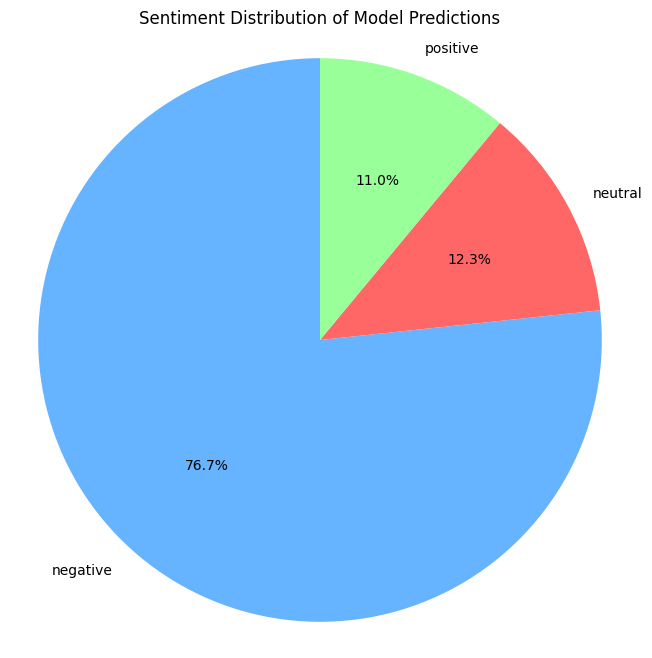

<ipython-input-11-5051523547c9>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentiment', palette="Set2")


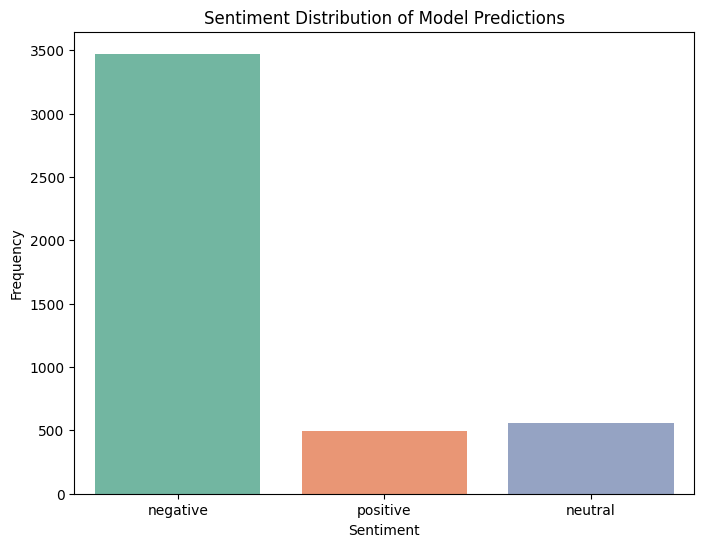

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Assuming you have a test or validation dataset and a trained model
# You can predict sentiments for each review in the test set like this

# Example function to predict sentiment labels for test data (updated)
def predict_sentiments(model, test_data, device):
    model.eval()  # Set model to evaluation mode
    predictions = []
    with torch.no_grad():  # Disable gradient calculation during inference
        for batch in test_data:  # Iterate through batches in the DataLoader
            inputs, _ = batch  # Unpack the batch, ignoring labels if present
            inputs = {k: v.to(device) for k, v in inputs.items()} # Move inputs to the correct device
            outputs = model(**inputs)  # Get model predictions
            logits = outputs.logits
            predicted_class = torch.argmax(logits, dim=1)
            predictions.extend(predicted_class.cpu().numpy())
    return predictions

# Example of how you might call this function (replace `val_loader` with your actual test data)
test_data = val_loader  # Use val_loader for prediction in this example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions = predict_sentiments(model, test_data, device)

# Convert numerical predictions to sentiment labels (assuming 0: Negative, 1: Neutral, 2: Positive)
sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
sentiment_labels = [sentiment_map[pred] for pred in predictions]

# ... (rest of the code for visualization remains the same) ...
import pandas as pd
df = pd.DataFrame(sentiment_labels, columns=['Sentiment'])

# Plotting a Pie chart for sentiment distribution
plt.figure(figsize=(8, 8))
sentiment_counts = df['Sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666', '#99ff99'])
plt.title("Sentiment Distribution of Model Predictions")
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()

# Plotting a Bar chart for sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Sentiment', palette="Set2")
plt.title("Sentiment Distribution of Model Predictions")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()